In [40]:
get_ipython().magic('matplotlib inline')
get_ipython().magic('config InlineBackend.figure_format = "retina"')
# %matplotlib inline
# %config IPython.matplotlib.backend = "retina"

import sys
import matplotlib.pyplot as pl
from matplotlib import rcParams
rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 150
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
if sys.platform == 'linux':
    rcParams["font.sans-serif"] = ["Ubuntu"]
else:
    rcParams["font.sans-serif"] = ["Arial"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [86]:
import os
import numpy as np
import warnings
from astropy.io import fits
from astropy.utils.exceptions import AstropyWarning
import matplotlib.pyplot as pl
from matplotlib.colors import LogNorm
from seaborn.cm import mako as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob

def normalize_01(im):
    return (im - im.min())/(im.max() - im.min())

class Speckle:

    def __init__(self, name, data_dir, inst="NESSI"):

        self.name = name
        self.data_dir = data_dir
        self.inst = inst
        if inst == "NESSI":
            self.blue_name = 'b'
            self.red_name = 'r'
            self.blue_wav = 562
            self.red_wav = 832
            self.skiprows = 19
        elif inst == "DSSI":
            self.blue_name = 'a'
            self.red_name = 'b'
            self.blue_wav = 692
            self.red_wav = 880            
            self.skiprows = 29
        elif inst == "Zorro":
            self.blue_name = 'b'
            self.red_name = 'r'
            self.blue_wav = 562
            self.red_wav = 832
            self.skiprows = 29
            
        self._load(name, data_dir)


    def _load(self, name, data_dir):

        print("Loading {} data".format(name))

        fp = glob.glob(os.path.join(data_dir, '{}*{}.fits'.format(name, self.blue_name)))[0]
        hl = fits.open(fp)
        self._fits_b = hl
        self._im_b = normalize_01(hl[0].data)
        self._hdr_b = hl[0].header

        fp = glob.glob(os.path.join(data_dir, '{}*{}.fits'.format(name, self.red_name)))[0]
        hl = fits.open(fp)
        self._fits_r = hl
        self._im_r = normalize_01(hl[0].data)
        self._hdr_r = hl[0].header

        fp = glob.glob(os.path.join(data_dir, '{}*{}.dat'.format(name, self.blue_name)))[0]
        self._cc_b = np.loadtxt(fp, skiprows=self.skiprows)

        fp = glob.glob(os.path.join(data_dir, '{}*{}.dat'.format(name, self.red_name)))[0]
        self._cc_r = np.loadtxt(fp, skiprows=self.skiprows)

        print("Data taken on {}".format(self.obs_date))


    @property
    def obs_date(self):
        return self._hdr_r['DATE-OBS']


    def plot(self, fp=None, save=True, stretch=1, figsize=(5,3.5), c1='C0', c2='C1', fs=10):

#         colors = ['navy', 'turquoise', 'darkorange']
#         colors = ['navy', 'darkorange']
        colors = [c1, c2]
        
        fontsize=30
        pl.style.use('seaborn-ticks')

#         rcParams['font.family'] = 'serif'
        rcParams["font.sans-serif"] = ["Ubuntu"]
        rcParams['axes.facecolor'] = 'white'

        fig,ax = pl.subplots(1, 1, figsize=figsize, sharex=True, sharey=True)

        rho, theta = self._cc_b.T
        ax.plot(rho, theta, label='{} nm'.format(self.blue_wav), color=colors[0], lw=2)

        rho, theta = self._cc_r.T
        ax.plot(rho, theta, label='{} nm'.format(self.red_wav), color=colors[1], lw=2)
        ax.invert_yaxis()
        ax.xaxis.set_ticks_position('both')
        ax.yaxis.set_ticks_position('both')
        ax.minorticks_on()

        ax1 = inset_axes(ax, 4.4, 1.3, borderpad=1.5)
        vmin, vmax = np.percentile(self._im_b, 0.1), np.percentile(self._im_b, 99.9)
        im = ax1.imshow(self._im_b, cmap=cm, norm=LogNorm(vmin=vmin, vmax=vmax), interpolation='none')
        ax1.xaxis.set_visible(False)
        ax1.yaxis.set_visible(False)
        ax1.set_title('{} nm'.format(self.blue_wav), fontsize=fs)
#         pixscale = 0.0175649 # arcsec/pixel
        pixscale = self._hdr_b['PIXSCL']
        arcsec = int(round(1/pixscale))
        xl, yl = ax1.get_xlim(), ax1.get_ylim()
        xcoord = [xl[1]-1.3*arcsec, xl[1]-0.3*arcsec]
        ycoord = [yl[0]+0.07*np.diff(yl), yl[0]+0.07*np.diff(yl)]
        ax1.plot(xcoord, ycoord, color='white')
        if self.inst == "NESSI":
            ax1.text(xcoord[0]*0.95, ycoord[0]*0.95, '1 arcsec', color='white', fontsize=fs)
        elif self.inst == "DSSI":
            ax1.text(xcoord[0]*1.08, ycoord[0]*0.95, '1 arcsec', color='white', fontsize=fs)
        elif self.inst == "Zorro":
            ax1.text(xcoord[0]*0.99, ycoord[0]*0.95, '1 arcsec', color='white', fontsize=fs)

        ax2 = inset_axes(ax, 1.3, 1.3, borderpad=1.5)
        vmin, vmax = np.percentile(self._im_r, 0.1), np.percentile(self._im_r, 99.9)
        im = ax2.imshow(self._im_r, cmap=cm, norm=LogNorm(vmin=vmin, vmax=vmax), interpolation='none')
        ax2.xaxis.set_visible(False)
        ax2.yaxis.set_visible(False)
        ax2.set_title('{} nm'.format(self.red_wav), fontsize=fs)
#         pixscale = 0.0181887 # arcsec/pixel
        pixscale = self._hdr_r['PIXSCL']
        arcsec = int(round(1/pixscale))
        xl, yl = ax2.get_xlim(), ax2.get_ylim()
        xcoord = [xl[1]-1.3*arcsec, xl[1]-0.3*arcsec]
        ycoord = [yl[0]+0.07*np.diff(yl), yl[0]+0.07*np.diff(yl)]
        ax2.plot(xcoord, ycoord, color='white')
        if self.inst == "NESSI":
            ax2.text(xcoord[0]*0.95, ycoord[0]*0.95, '1 arcsec', color='white', fontsize=fs)
        elif self.inst == "DSSI":
            ax2.text(xcoord[0]*1.05, ycoord[0]*0.95, '1 arcsec', color='white', fontsize=fs)
        elif self.inst == "Zorro":
            ax2.text(xcoord[0]*0.95, ycoord[0]*0.95, '1 arcsec', color='white', fontsize=fs)

        yl = ax.get_ylim()
        ylim = (stretch * yl[0], yl[1])
        pl.setp(ax,
                title=self.name,
                xlabel=r'$\Delta$arcsec',
                ylabel=r'$\Delta$mag',
                xlim=(rho.min(), rho.max()),
                ylim=ylim)

        ax.legend(loc='lower left', frameon=False)

        fig.tight_layout()
        if fp is None and save:
            fp = '{}_{}.png'.format(self.name, self.obs_date)
            fig.savefig(fp, dpi=400)
            pl.close()

        print("Wrote file: {}".format(fp))

In [87]:
name = 'TOI704'
data_dir = '{}/mega/missions/tess/toi704/speckle'.format(os.environ['HOME'])
spkl = Speckle(name, data_dir, inst="Zorro")

Loading TOI704 data
Data taken on 2020-10-09


                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                

/home/jhl/miniconda3/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


Wrote file: None


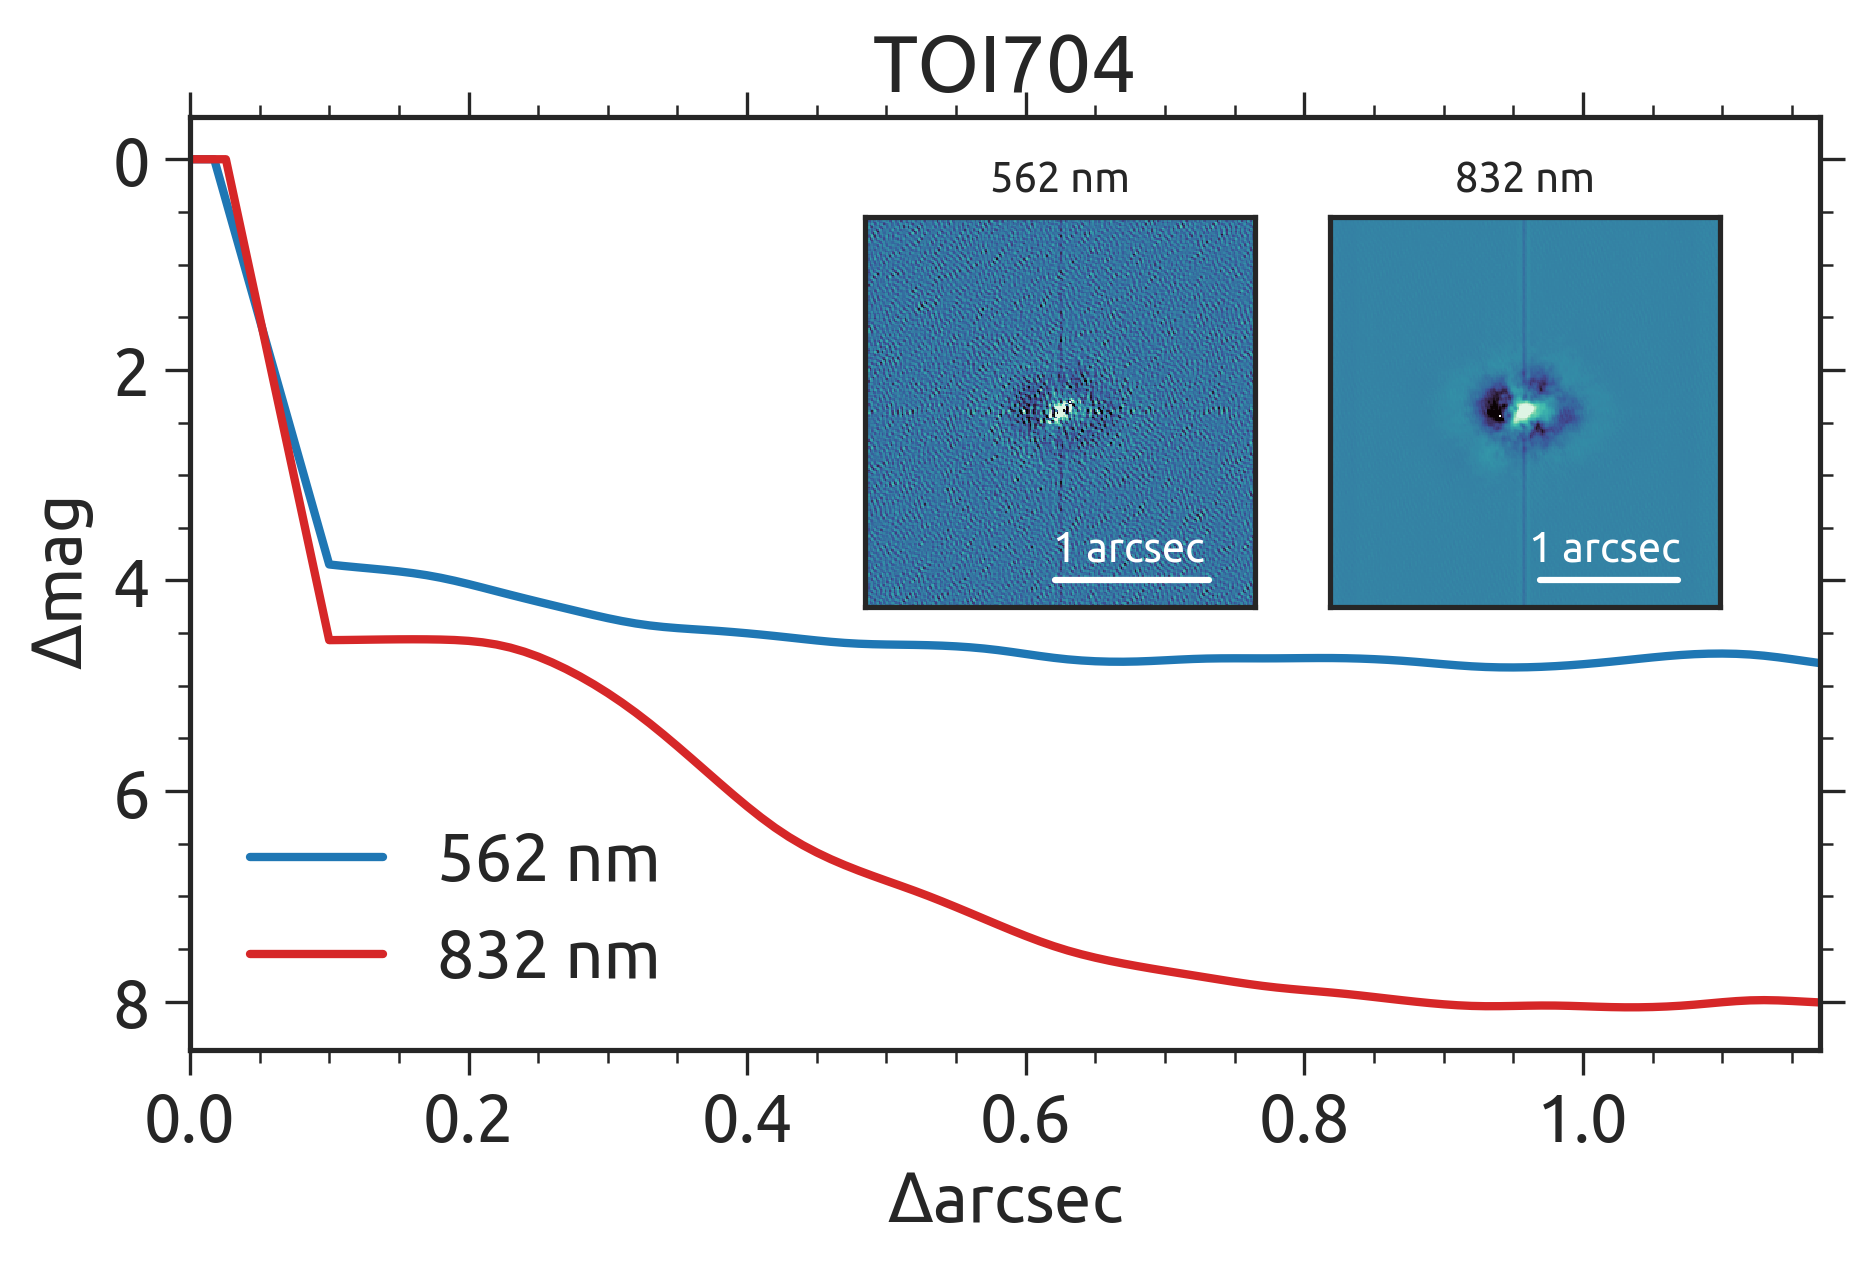

In [88]:
spkl.plot(stretch=1., save=False, figsize=(6.5,4.5), c2='C3')

In [89]:
spkl.plot(stretch=1., save=True, figsize=(6.5,4.5), c2='C3')

/home/jhl/miniconda3/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


Wrote file: TOI704_2020-10-09.png


In [8]:
name = 'TOI704'
data_dir = '{}/mega/missions/tess/toi704/speckle'.format(os.environ['HOME'])
blue_name = 'b'

fp = glob.glob(os.path.join(data_dir, '{}*{}.fits'.format(name, blue_name)))[0]
hl = fits.open(fp)
hl[0].header

                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                

SIMPLE  =                    T / Written by IDL:  Mon Oct 21 10:13:40 2019      
BITPIX  =                  -32 / Number of bits per data pixel                  
NAXIS   =                    2 / Number of data axes                            
NAXIS1  =                  256 /                                                
NAXIS2  =                  256 /                                                
EXTEND  =                    T / FITS data may contain extensions               
DATE    = '2019-10-21'         / Creation UTC (CCCC-MM-DD) date of FITS header  
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    
CAMERA  = 'b'          / Camera                                                 
PIXSCL  =    0.00991900 / Pixel scale (arcsec/pixel)                            
FILTER  = '562'        / Filter                                                 
ORIGFL  = 'h100000_f1b'     

In [9]:
name = 'TOI704'
data_dir = '{}/mega/missions/tess/toi704/speckle'.format(os.environ['HOME'])
blue_name = 'r'

fp = glob.glob(os.path.join(data_dir, '{}*{}.fits'.format(name, blue_name)))[0]
hl = fits.open(fp)
hl[0].header

                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                

SIMPLE  =                    T / Written by IDL:  Mon Oct 21 10:13:41 2019      
BITPIX  =                  -32 / Number of bits per data pixel                  
NAXIS   =                    2 / Number of data axes                            
NAXIS1  =                  256 /                                                
NAXIS2  =                  256 /                                                
EXTEND  =                    T / FITS data may contain extensions               
DATE    = '2019-10-21'         / Creation UTC (CCCC-MM-DD) date of FITS header  
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    
CAMERA  = 'r'          / Camera                                                 
PIXSCL  =     0.0109530 / Pixel scale (arcsec/pixel)                            
FILTER  = '832'        / Filter                                                 
ORIGFL  = 'h100000_f1r'     

In [7]:
data_dir

'~/mega/missions/tess/toi704/speckle'

In [6]:
data_dir
glob.glob(os.path.join(data_dir, '{}*{}.fits'.format(name, blue_name)))

[]

In [39]:
spkl.plot(stretch=1.2)

/Users/jhl/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Wrote file: 249893012_2018-04-01.png


In [40]:
fp = "/Users/jhl/Downloads/249893012I-sh20180401a.fits"
fits.open(fp)[0].header

                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
                                                                

SIMPLE  =                    T / Written by IDL:  Thu Nov 08 12:00:30 2018      
BITPIX  =                  -32 / Number of bits per data pixel                  
NAXIS   =                    2 / Number of data axes                            
NAXIS1  =                  256 /                                                
NAXIS2  =                  256 /                                                
EXTEND  =                    T / FITS data may contain extensions               
DATE    = '2018-11-08'         / Creation UTC (CCCC-MM-DD) date of FITS header  
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    
CAMERA  = 'a'          / Camera                                                 
PIXSCL  =     0.0107980 / Pixel scale (arcsec/pixel)                            
FILTER  = '692'        / Filter                                                 
ORIGFL  = 'h621081_f1a'     